In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


# Load the data
X_train = pd.read_csv('/content/X_Train_Data_Input.csv')
Y_train = pd.read_csv('/content/Y_Train_Data_Target.csv')
X_test = pd.read_csv('/content/X_Test_Data_Input.csv')
Y_test = pd.read_csv('/content/Y_Test_Data_Target.csv')

# Drop the 'ID' column from X_train and X_test
X_train_clean = X_train.drop(columns=['ID'])
X_test_clean = X_test.drop(columns=['ID'])

# Drop the 'ID' column from Y_train and Y_test
Y_train_clean = Y_train.drop(columns=['ID'])
Y_test_clean = Y_test.drop(columns=['ID'])

# Ensure Y_train and Y_test are in the correct format (1D array)
Y_train_clean = Y_train_clean.values.ravel()
Y_test_clean = Y_test_clean.values.ravel()

# Check the shapes
print(f'X_train_clean shape: {X_train_clean.shape}')  # Should be 2D
print(f'Y_train_clean shape: {Y_train_clean.shape}')  # Should be 1D

# Check for sample mismatches
if X_train_clean.shape[0] != Y_train_clean.shape[0]:
    print(f"Mismatch found: X_train has {X_train_clean.shape[0]} samples, Y_train has {Y_train_clean.shape[0]} samples.")

    # If they are mismatched, align them based on the index
    # Create a DataFrame with indices to filter Y_train_clean
    valid_indices = X_train.index.intersection(Y_train.index)
    X_train_clean = X_train_clean.loc[valid_indices]
    Y_train_clean = Y_train_clean[valid_indices]

# Define categorical columns for encoding (if any)
categorical_columns = X_train_clean.select_dtypes(include=['object']).columns

# Define a column transformer to handle both numeric and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), X_train_clean.select_dtypes(exclude=['object']).columns),  # Numeric columns
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)  # Categorical columns (if any)
    ]
)

# Build a pipeline that preprocesses the data and scales it
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())  # Scale numerical data
])

# Apply the preprocessing pipeline to training and test data
X_train_preprocessed = pipeline.fit_transform(X_train_clean)
X_test_preprocessed = pipeline.transform(X_test_clean)

print(f'Preprocessed X_train shape: {X_train_preprocessed.shape}')
print(f'Preprocessed X_test shape: {X_test_preprocessed.shape}')



X_train_clean shape: (785133, 22)
Y_train_clean shape: (785133,)
Preprocessed X_train shape: (785133, 22)
Preprocessed X_test shape: (261712, 22)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV  # Use RandomizedSearchCV for faster search

# Sample the training data if needed
X_train_sample = X_train_preprocessed[:1000]  # Sample the first 1000 rows
Y_train_sample = Y_train_clean[:1000]          # Corresponding labels

# Define the parameter grid
rf_param_grid = {
    'n_estimators': [50],  # Start with a smaller number of estimators
    'max_depth': [None, 10],  # Testing max_depth values
    'min_samples_split': [2]  # Minimal splitting
}

# Perform randomized search instead of grid search
rf_random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_param_grid,
                                       n_iter=5,  # Fewer iterations for faster results
                                       cv=2, scoring='accuracy', n_jobs=-1)
rf_random_search.fit(X_train_sample, Y_train_sample)  # Fit on the sampled data

# Get the best model
model_1 = rf_random_search.best_estimator_


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [ ]:
# Hyperparameter tuning for Gradient Boosting
gb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
gb_random_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=42),
                                       gb_param_grid, n_iter=5, cv=2, scoring='accuracy', n_jobs=-1)

print("Starting Gradient Boosting Hyperparameter Tuning...")
gb_random_search.fit(X_train_sample, Y_train_sample)
model_2 = gb_random_search.best_estimator_
print("Finished Gradient Boosting Hyperparameter Tuning.")


Starting Gradient Boosting Hyperparameter Tuning...
Finished Gradient Boosting Hyperparameter Tuning.


In [ ]:
# Logistic Regression with default parameters
model_3 = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
model_3.fit(X_train_preprocessed, Y_train_clean)

# Check performance of individual models first
for model_name, model in {'Model 1': model_1, 'Model 2': model_2, 'Model 3': model_3}.items():
    print(f"Evaluating {model_name}...")
    model.fit(X_train_preprocessed, Y_train_clean)
    print(f"Finished training {model_name}.")


Evaluating Model 1...
Finished training Model 1.
Evaluating Model 2...
Finished training Model 2.
Evaluating Model 3...
Finished training Model 3.


In [ ]:
# Combination 1 (Model 4): Random Forest + Gradient Boosting (Voting Classifier)
model_4 = VotingClassifier(estimators=[('rf', model_1), ('gb', model_2)], voting='soft')
model_4.fit(X_train_preprocessed, Y_train_clean)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft')

In [ ]:
# Combination 2 (Model 5): Random Forest + Logistic Regression (Voting Classifier)
model_5 = VotingClassifier(estimators=[('rf', model_1), ('lr', model_3)], voting='soft')
model_5.fit(X_train_preprocessed, Y_train_clean)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=42)),
                             ('lr',
                              LogisticRegression(max_iter=1000, n_jobs=-1,
                                                 random_state=42))],
                 voting='soft')

In [ ]:
# Combination 3 (Model 6): Gradient Boosting + Logistic Regression (Voting Classifier)
model_6 = VotingClassifier(estimators=[('gb', model_2), ('lr', model_3)], voting='soft')
model_6.fit(X_train_preprocessed, Y_train_clean)



VotingClassifier(estimators=[('gb',
                              GradientBoostingClassifier(random_state=42)),
                             ('lr',
                              LogisticRegression(max_iter=1000, n_jobs=-1,
                                                 random_state=42))],
                 voting='soft')

In [ ]:
# Combination 4 (Model 7): Random Forest + Gradient Boosting + Logistic Regression (Voting Classifier)
model_7 = VotingClassifier(estimators=[('rf', model_1), ('gb', model_2), ('lr', model_3)], voting='soft')
model_7.fit(X_train_preprocessed, Y_train_clean)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42)),
                             ('lr',
                              LogisticRegression(max_iter=1000, n_jobs=-1,
                                                 random_state=42))],
                 voting='soft')

In [ ]:
models = {
    'Model 1 (Random Forest)': model_1,
    'Model 2 (Gradient Boosting)': model_2,
    'Model 3 (Logistic Regression)': model_3,
    'Model 4 (RF + GB)': model_4,
    'Model 5 (RF + LR)': model_5,
    'Model 6 (GB + LR)': model_6,
    'Model 7 (RF + GB + LR)': model_7
}

Evaluating Model 1 (Random Forest)...
Accuracy for Model 1 (Random Forest): 0.9765199914409732
Classification Report for Model 1 (Random Forest):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    237034
           1       0.85      0.91      0.88     24678

    accuracy                           0.98    261712
   macro avg       0.92      0.95      0.93    261712
weighted avg       0.98      0.98      0.98    261712

AUC-ROC for Model 1 (Random Forest): 0.9939614660701517


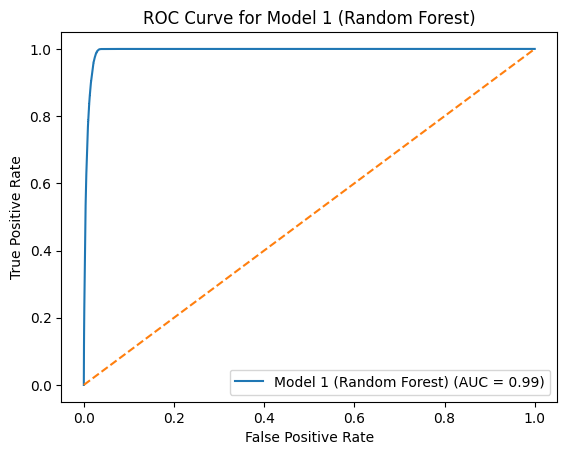

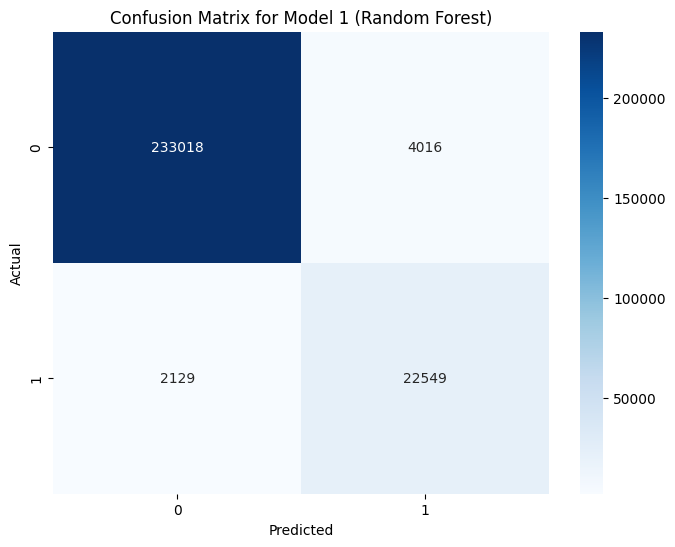

Evaluating Model 2 (Gradient Boosting)...
Accuracy for Model 2 (Gradient Boosting): 0.9761875649568992
Classification Report for Model 2 (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    237034
           1       0.83      0.95      0.88     24678

    accuracy                           0.98    261712
   macro avg       0.91      0.96      0.93    261712
weighted avg       0.98      0.98      0.98    261712

AUC-ROC for Model 2 (Gradient Boosting): 0.9938779456995819


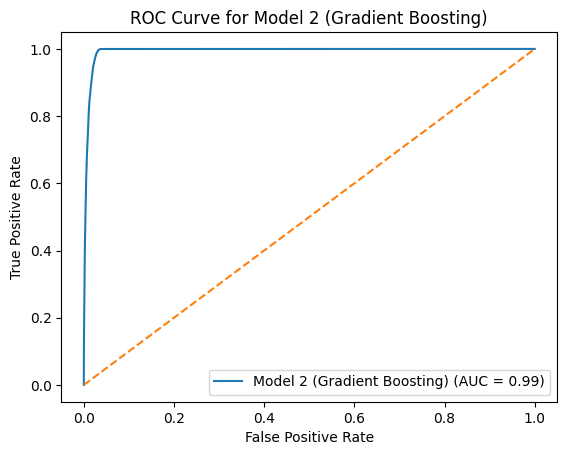

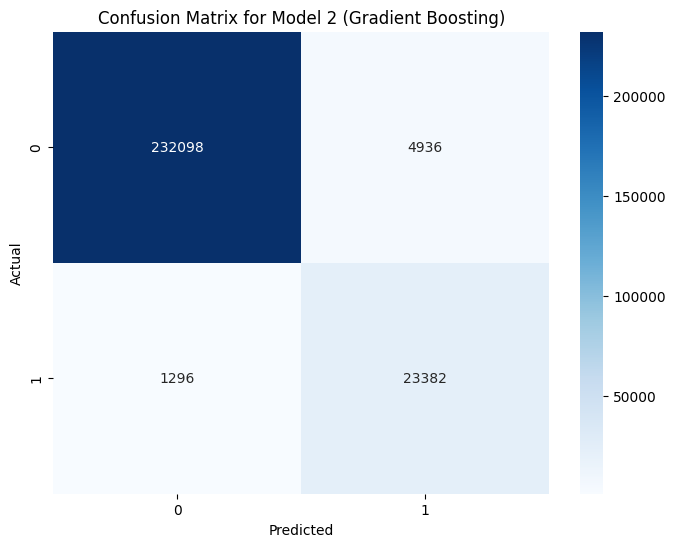

Evaluating Model 3 (Logistic Regression)...
Accuracy for Model 3 (Logistic Regression): 0.9691416518921563
Classification Report for Model 3 (Logistic Regression):
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    237034
           1       0.81      0.89      0.84     24678

    accuracy                           0.97    261712
   macro avg       0.90      0.93      0.91    261712
weighted avg       0.97      0.97      0.97    261712

AUC-ROC for Model 3 (Logistic Regression): 0.9892355908487868


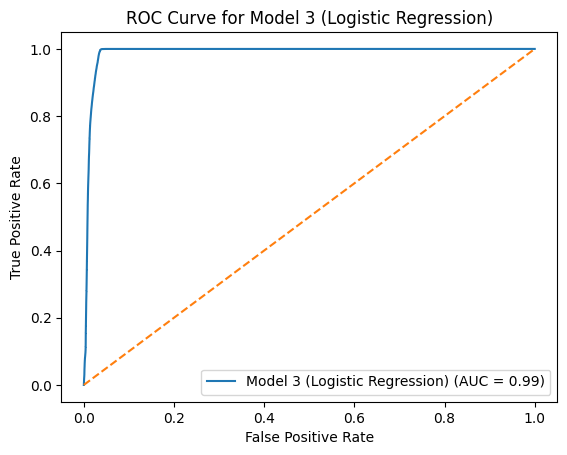

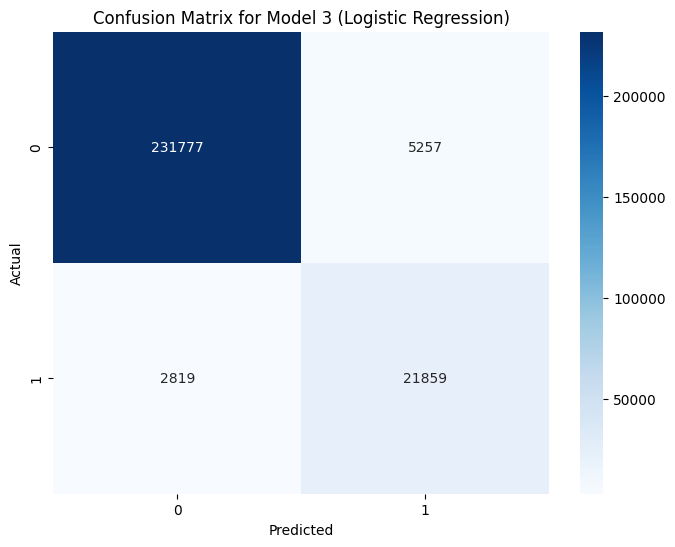

Evaluating Model 4 (RF + GB)...
Accuracy for Model 4 (RF + GB): 0.9772268753438894
Classification Report for Model 4 (RF + GB):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    237034
           1       0.84      0.94      0.89     24678

    accuracy                           0.98    261712
   macro avg       0.92      0.96      0.94    261712
weighted avg       0.98      0.98      0.98    261712

AUC-ROC for Model 4 (RF + GB): 0.9943461348218874


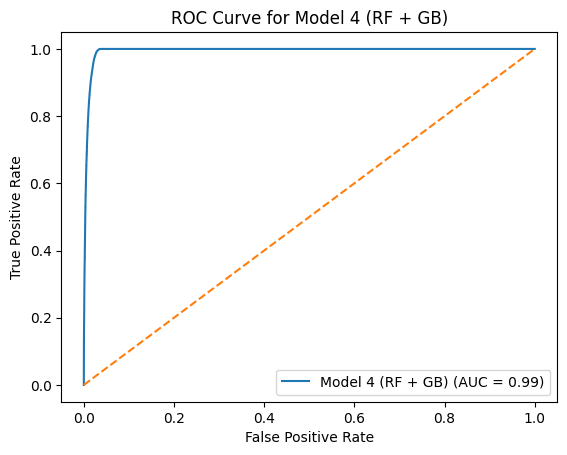

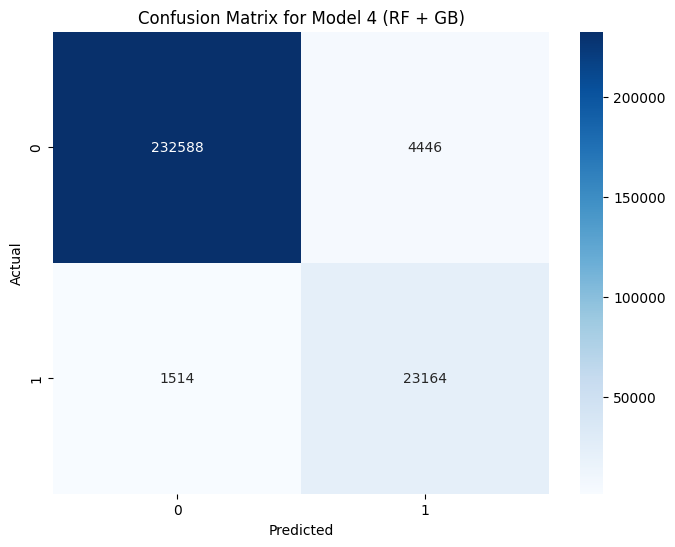

Evaluating Model 5 (RF + LR)...
Accuracy for Model 5 (RF + LR): 0.9748998899553708
Classification Report for Model 5 (RF + LR):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    237034
           1       0.83      0.92      0.87     24678

    accuracy                           0.97    261712
   macro avg       0.91      0.95      0.93    261712
weighted avg       0.98      0.97      0.98    261712

AUC-ROC for Model 5 (RF + LR): 0.9932847171093713


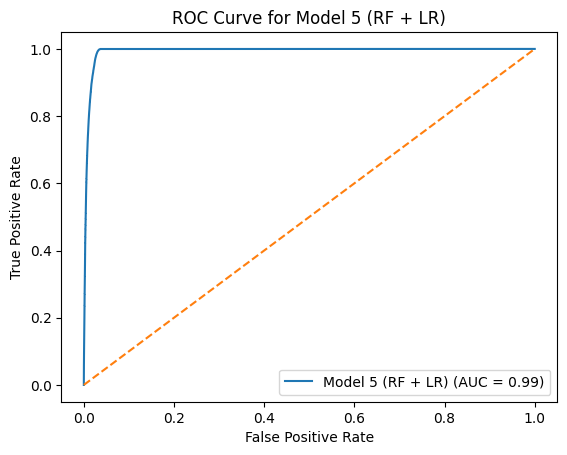

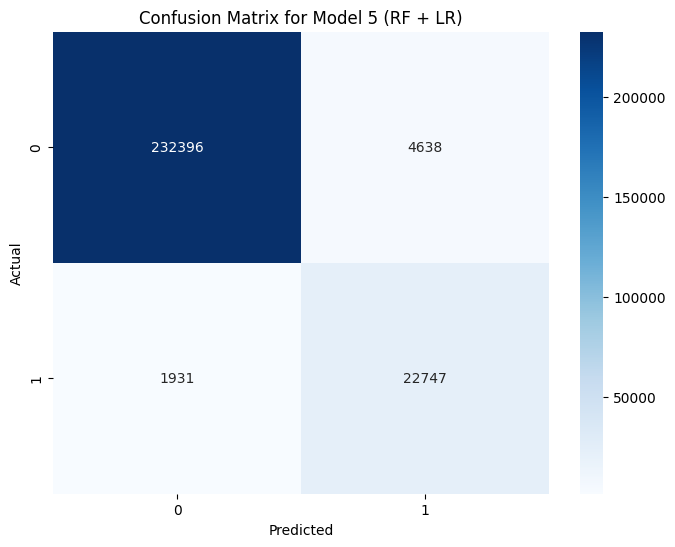

Evaluating Model 6 (GB + LR)...
Accuracy for Model 6 (GB + LR): 0.9729053310509262
Classification Report for Model 6 (GB + LR):
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    237034
           1       0.82      0.92      0.86     24678

    accuracy                           0.97    261712
   macro avg       0.90      0.95      0.92    261712
weighted avg       0.97      0.97      0.97    261712

AUC-ROC for Model 6 (GB + LR): 0.9926541017231291


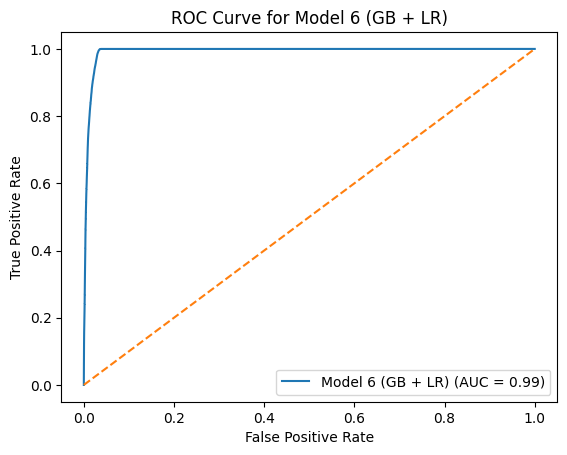

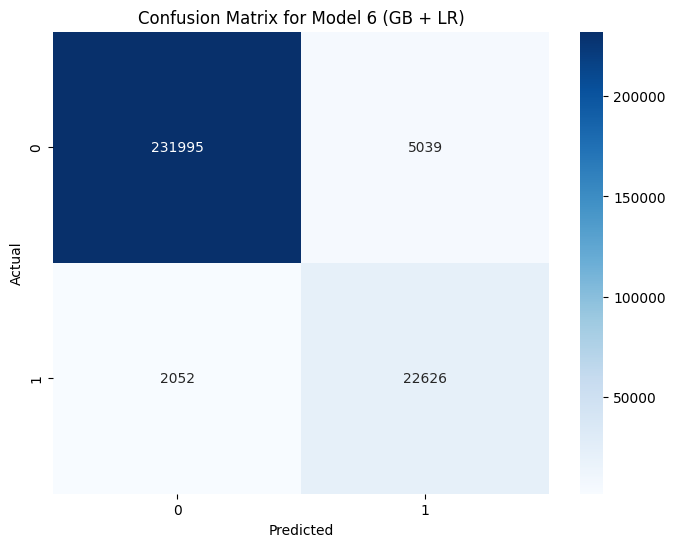

Evaluating Model 7 (RF + GB + LR)...
Accuracy for Model 7 (RF + GB + LR): 0.9761455340221312
Classification Report for Model 7 (RF + GB + LR):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    237034
           1       0.83      0.94      0.88     24678

    accuracy                           0.98    261712
   macro avg       0.91      0.96      0.93    261712
weighted avg       0.98      0.98      0.98    261712

AUC-ROC for Model 7 (RF + GB + LR): 0.9938316504025121


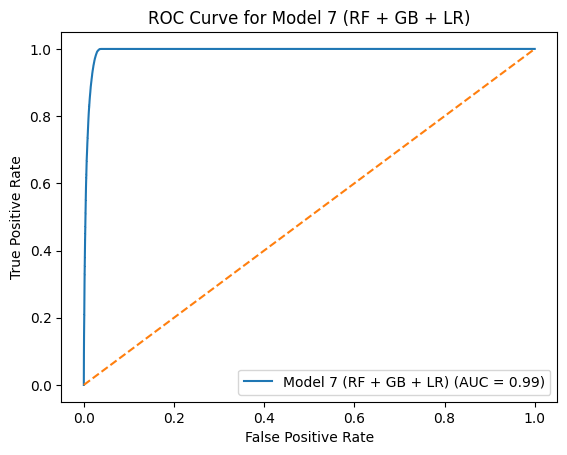

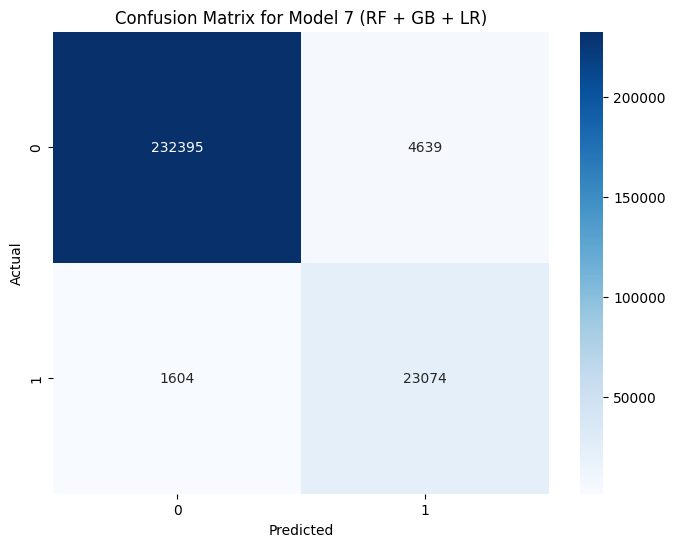

In [ ]:
# Evaluate each model
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    # Predict on test set
    Y_test_pred = model.predict(X_test_preprocessed)
    accuracy = accuracy_score(Y_test_clean, Y_test_pred)
    clf_report = classification_report(Y_test_clean, Y_test_pred)

    # ROC-AUC for binary classification
    Y_test_pred_proba = model.predict_proba(X_test_preprocessed)[:, 1]
    auc_roc = roc_auc_score(Y_test_clean, Y_test_pred_proba)

    # Print results
    print(f"Accuracy for {model_name}: {accuracy}")
    print(f"Classification Report for {model_name}:\n{clf_report}")
    print(f"AUC-ROC for {model_name}: {auc_roc}")

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(Y_test_clean, Y_test_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_roc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')  # Random classifier line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(Y_test_clean, Y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()